# UniVI CITE-seq data integration demonstration/tutorial

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/17/2025

This Jupyter Notebook will be used to outline the training steps for a UniVI model using human PBMC CITE-seq data.


#### Import modules

In [1]:
import os, sys, json
import numpy as np
import scanpy as sc
import torch


In [2]:
# -------------------------
# 0. Wire up package import
# -------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


Project root: /home/groups/precepts/ashforda/UniVI_v2/UniVI


#### Initialize data via data loaders

In [3]:
# -------------------------
# 1. Load config JSON
# -------------------------
with open("../parameter_files/defaults_cite_seq_raw_counts.json") as f:
    cfg_json = json.load(f)

data_cfg = cfg_json["data"]
model_cfg = cfg_json["model"]
train_cfg_json = cfg_json["training"]

device = train_cfg_json.get("device", "cuda")

if device == "cuda" and not torch.cuda.is_available():
    print("CUDA not available; falling back to CPU.")
    device = "cpu"


In [4]:
print(data_cfg)
print(model_cfg)
print(train_cfg_json)


{'modalities': [{'name': 'rna', 'h5ad_path': '../data/Hao_RNA_data.h5ad', 'layer': None, 'X_key': 'X', 'hidden_dims': [512, 256], 'likelihood': 'nb'}, {'name': 'adt', 'h5ad_path': '../data/Hao_ADT_data.h5ad', 'layer': None, 'X_key': 'X', 'hidden_dims': [128, 64], 'likelihood': 'nb'}]}
{'latent_dim': 40, 'hidden_dims_default': [256, 128], 'dropout': 0.1, 'batchnorm': True, 'beta': 20.0, 'gamma': 80.0, 'kl_anneal_start': 10, 'kl_anneal_end': 50, 'align_anneal_start': 10, 'align_anneal_end': 50}
{'seed': 42, 'train_fraction': 0.8, 'batch_size': 256, 'num_workers': 0, 'n_epochs': 200, 'lr': 0.001, 'weight_decay': 0.0001, 'grad_clip': 5.0, 'device': 'cpu', 'log_every': 1, 'early_stopping': True, 'patience': 20, 'min_delta': 0.0}


In [5]:
# -------------------------
# 2. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/Hao_RNA_data.h5ad")


/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [6]:
# Sanity check
print(rna_adata)
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'
  (0, 1)	0.6931471805599453
  (0, 19)	0.6931471805599453
  (0, 23)	0.6931471805599453
  (0, 28)	0.6931471805599453
  (0, 30)	1.3862943611198906
  (0, 48)	0.6931471805599453
  (0, 49)	1.3862943611198906
  (0, 54)	0.6931471805599453
  (0, 57)	1.0986122886681096
  (0, 63)	0.6931471805599453
  (0, 82)	2.1972245773362196
  (0, 98)	0.6931471805599453
  (0, 99)	0.6931471805599453
  (0, 111)	1.791759469228055
  (0, 127)	0.6931471805599453
  (0, 138)	0.6931471805599453
  (0, 149)	0.6931471805599453
  (0, 151)	1.6094379124341003
  (0, 157)	0.6931471805599453
  (0, 159)	0.6931471805599453
  (0, 160)	0

In [7]:
# Change the RNA counts to raw counts so they're not log-normalized and use ZINB or NB as the decoder distribution
# for model training
rna_adata.layers['log1p'] = rna_adata.X
rna_adata.X = rna_adata.raw.X


In [8]:
# Sanity check
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


  (0, 1)	1.0
  (0, 19)	1.0
  (0, 23)	1.0
  (0, 28)	1.0
  (0, 30)	3.0
  (0, 48)	1.0
  (0, 49)	3.0
  (0, 54)	1.0
  (0, 57)	2.0
  (0, 63)	1.0
  (0, 82)	8.0
  (0, 98)	1.0
  (0, 99)	1.0
  (0, 111)	5.0
  (0, 127)	1.0
  (0, 138)	1.0
  (0, 149)	1.0
  (0, 151)	4.0
  (0, 157)	1.0
  (0, 159)	1.0
  (0, 160)	1.0
  (0, 161)	1.0
  (0, 162)	1.0
  (0, 170)	2.0
  (0, 182)	1.0
  :	:
  (161763, 16110)	4.0
  (161763, 16113)	4.0
  (161763, 16130)	1.0
  (161763, 16158)	3.0
  (161763, 16159)	4.0
  (161763, 16160)	8.0
  (161763, 16163)	1.0
  (161763, 16184)	33.0
  (161763, 16185)	34.0
  (161763, 16186)	99.0
  (161763, 16187)	72.0
  (161763, 16188)	1.0
  (161763, 16189)	64.0
  (161763, 16190)	75.0
  (161763, 16191)	53.0
  (161763, 16193)	31.0
  (161763, 16194)	9.0
  (161763, 16196)	51.0
  (161763, 16350)	1.0
  (161763, 16585)	1.0
  (161763, 16688)	1.0
  (161763, 17511)	1.0
  (161763, 17866)	3.0
  (161763, 18249)	1.0
  (161763, 18702)	1.0
0.0
8513.0


In [9]:
# If your counts are in rna_adata.X (raw or log-normalized), this is fine:
sc.pp.highly_variable_genes(
    rna_adata,
    layer='log1p',
    n_top_genes=2000,
    flavor="seurat",   # or "cell_ranger" / "seurat_v3"
    inplace=True,
)


/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [10]:
# Boolean mask of HVGs
hvg_mask = rna_adata.var["highly_variable"].values

# Names of the top HVGs
hvg_genes = rna_adata.var_names[hvg_mask].tolist()
print(f"Selected {len(hvg_genes)} highly variable genes.")
print(hvg_genes[:20])  # peek at first few


Selected 2000 highly variable genes.
['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'RBP7', 'EPHA2', 'PADI4', 'CDA', 'EIF4G3', 'AL031005.1', 'C1QA', 'C1QC', 'C1QB', 'TCEA3', 'ID3', 'RCAN3', 'LDLRAP1', 'STMN1', 'ZNF683', 'IFI6']


In [11]:
# Optional: make a HVG-only AnnData for modeling
rna_adata_hvg = rna_adata[:, hvg_mask].copy()
print(rna_adata_hvg)


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'


In [12]:
# Load ADT AnnData object
adt_adata = sc.read_h5ad("../data/Hao_ADT_data.h5ad")


In [13]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
[[1.95916424 0.86914159 1.48523314 ... 0.55307644 1.04608444 1.72565693]
 [0.4322284  1.01422751 0.79594998 ... 0.66587988 0.85514588 1.37971736]
 [0.61381759 1.30390619 0.75610373 ... 0.6874892  0.75610373 1.04246048]
 ...
 [1.50685426 0.54914608 1.0656108  ... 0.25674036 0.25674036 1.16168749]
 [1.63537843 0.32520632 1.19570797 ... 0.45519093 0.51435145 2.10485699]
 [1.58503    0.64458811 1.61118685 ... 0.416905   0.23002318 2.07731277]]
0.0
8.589231339100166


In [14]:
# Set the ADT data to raw counts and use a NB or ZINB decoder in model training and save the current .X counts to
# .layers['log1p']
adt_adata.layers['log1p'] = adt_adata.X
adt_adata.X = adt_adata.raw.X


In [15]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'log1p'
  (0, 0)	66.0
  (0, 1)	15.0
  (0, 2)	37.0
  (0, 3)	142.0
  (0, 4)	4.0
  (0, 5)	3.0
  (0, 6)	242.0
  (0, 7)	9.0
  (0, 8)	752.0
  (0, 9)	14.0
  (0, 10)	5.0
  (0, 11)	3.0
  (0, 13)	20.0
  (0, 14)	8.0
  (0, 15)	4.0
  (0, 16)	1.0
  (0, 17)	5.0
  (0, 18)	4.0
  (0, 19)	2.0
  (0, 20)	5.0
  (0, 21)	28.0
  (0, 22)	1.0
  (0, 23)	12.0
  (0, 24)	479.0
  (0, 25)	6.0
  :	:
  (161763, 203)	3.0
  (161763, 204)	2.0
  (161763, 205)	3.0
  (161763, 206)	34.0
  (161763, 207)	149.0
  (161763, 208)	38.0
  (161763, 209)	23.0
  (161763, 210)	79.0
  (161763, 211)	3.0
  (161763, 212)	109.0
  (161763, 213)	13.0
  (161763, 214)	5.0
  (161763, 215)	1.0

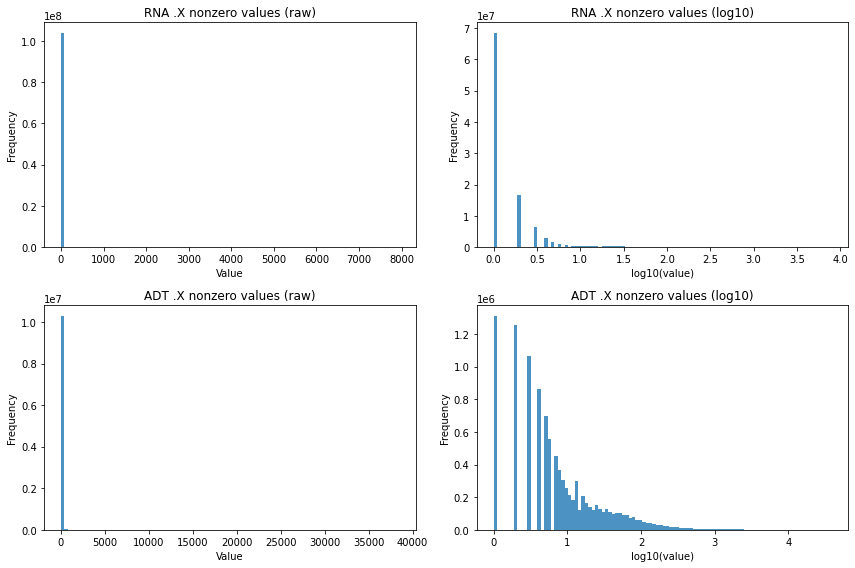

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def get_X_values(adata, n_cells: int = 5000):
    """
    Return flattened values from adata.X (optionally subsampled over cells).
    Uses only non-zero entries if X is sparse.
    """
    X = adata.X

    # Optional subsampling over cells (rows)
    if n_cells is not None and adata.n_obs > n_cells:
        idx = np.random.choice(adata.n_obs, size=n_cells, replace=False)
        X = X[idx]

    if sparse.issparse(X):
        vals = X.data  # nonzero values
    else:
        vals = np.asarray(X).ravel()

    # Remove zeros explicitly (just to focus on count/ADT magnitude)
    vals = vals[vals > 0]
    return vals

def plot_X_distribution(rna_adata, adt_adata, n_cells: int = 5000):
    rna_vals = get_X_values(rna_adata, n_cells=n_cells)
    adt_vals = get_X_values(adt_adata, n_cells=n_cells)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- RNA raw ---
    axes[0, 0].hist(rna_vals, bins=100, alpha=0.8)
    axes[0, 0].set_title("RNA .X nonzero values (raw)")
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Frequency")

    # --- RNA log10 ---
    axes[0, 1].hist(np.log10(rna_vals + 1e-8), bins=100, alpha=0.8)
    axes[0, 1].set_title("RNA .X nonzero values (log10)")
    axes[0, 1].set_xlabel("log10(value)")
    axes[0, 1].set_ylabel("Frequency")

    # --- ADT raw ---
    axes[1, 0].hist(adt_vals, bins=100, alpha=0.8)
    axes[1, 0].set_title("ADT .X nonzero values (raw)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Frequency")

    # --- ADT log10 ---
    axes[1, 1].hist(np.log10(adt_vals + 1e-8), bins=100, alpha=0.8)
    axes[1, 1].set_title("ADT .X nonzero values (log10)")
    axes[1, 1].set_xlabel("log10(value)")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call it:
plot_X_distribution(rna_adata, adt_adata, n_cells=50000)


In [17]:
# Create AnnData dictionary for both objects
adata_by_mod = {
    "rna": rna_adata_hvg,
    "adt": adt_adata,
}


In [ ]:
# Bipartite matching code
'''
import scanpy as sc

# Assume you have two *unpaired* datasets of the same tissue:
#   rna_adata_unpaired, adt_adata_unpaired

# You can do separate PCAs (simple version):
sc.pp.pca(rna_adata_unpaired, n_comps=50)
sc.pp.pca(adt_adata_unpaired, n_comps=50)

# This creates:
#   rna_adata_unpaired.obsm["X_pca"]
#   adt_adata_unpaired.obsm["X_pca"]
'''

'''
from univi.matching import bipartite_match_adata

matched_A, matched_B = bipartite_match_adata(
    adata_A=rna_adata_unpaired,
    adata_B=adt_adata_unpaired,
    emb_key="X_pca",      # or another embedding key
    metric="euclidean",   # can also try "cosine"
    max_cells=20000,      # or smaller/larger depending on memory
    random_state=0,
)

print(len(matched_A), len(matched_B))   # same length = number of pseudo-pairs
'''

'''
import numpy as np

# subset
rna_matched = rna_adata_unpaired[matched_A].copy()
adt_matched = adt_adata_unpaired[matched_B].copy()

# give them a shared index for MultiModalDataset
n_pairs = rna_matched.n_obs
new_index = np.array([f"pair_{i}" for i in range(n_pairs)], dtype=str)

rna_matched.obs_names = new_index
adt_matched.obs_names = new_index
'''

'''
adata_by_mod = {
    "rna": rna_matched,
    "adt": adt_matched,
}
'''

In [ ]:
# Subset by cell types for balanced model training and reduced computational expense and save to different adata
# objects for later use of the remaining cells as a test set so as not to re-use the training cells after training
'''
# With bipartite matching approach
#import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
#from univi.data import MultiModalDataset

# matched indices into the *original* adatas
# matched_rna_idx, matched_adt_idx from bipartite_match_adata(...)
n_matched = len(matched_rna_idx)
assert n_matched == len(matched_adt_idx)

# 1) build matched AnnData views (for clarity)
rna_matched = rna_adata[matched_rna_idx].copy()
adt_matched = adt_adata[matched_adt_idx].copy()

# 2) build dataset from matched adatas
adata_by_mod = {"rna": rna_matched, "adt": adt_matched}
full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod,
    X_key="X",                # or your chosen layer / key
    device=train_cfg.device,  # cpu or cuda
)

# 3) make train/val/test indices in *matched space* (0..n_matched-1)
indices = np.arange(n_matched)
rng = np.random.default_rng(train_cfg.seed)
rng.shuffle(indices)

frac_train = 0.8
frac_val   = 0.1
n_train = int(frac_train * n_matched)
n_val   = int(frac_val * n_matched)

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# 4) build dataloaders
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)  # for later eval

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)


# global indices (into original rna_adata / adt_adata)
rna_train_global = matched_rna_idx[train_idx]
rna_val_global   = matched_rna_idx[val_idx]
rna_test_global  = matched_rna_idx[test_idx]

adt_train_global = matched_adt_idx[train_idx]
adt_val_global   = matched_adt_idx[val_idx]
adt_test_global  = matched_adt_idx[test_idx]


def init_split_column(adata, col="univi_split"):
    if col not in adata.obs.columns:
        adata.obs[col] = "unused"

# initialize
init_split_column(rna_adata, "univi_split")
init_split_column(adt_adata, "univi_split")

# everything that was matched at all
rna_adata.obs.loc[matched_rna_idx, "univi_split"] = "matched"
adt_adata.obs.loc[matched_adt_idx, "univi_split"] = "matched"

# override for train / val / test
rna_adata.obs.loc[rna_train_global, "univi_split"] = "train"
rna_adata.obs.loc[rna_val_global,   "univi_split"] = "val"
rna_adata.obs.loc[rna_test_global,  "univi_split"] = "test"

adt_adata.obs.loc[adt_train_global, "univi_split"] = "train"
adt_adata.obs.loc[adt_val_global,   "univi_split"] = "val"
adt_adata.obs.loc[adt_test_global,  "univi_split"] = "test"


rna_train_adata = rna_adata[rna_adata.obs["univi_split"] == "train"].copy()
rna_val_adata   = rna_adata[rna_adata.obs["univi_split"] == "val"].copy()
rna_test_adata  = rna_adata[rna_adata.obs["univi_split"] == "test"].copy()
rna_unused      = rna_adata[rna_adata.obs["univi_split"] == "unused"].copy()

adt_train_adata = adt_adata[adt_adata.obs["univi_split"] == "train"].copy()
adt_val_adata   = adt_adata[adt_adata.obs["univi_split"] == "val"].copy()
adt_test_adata  = adt_adata[adt_adata.obs["univi_split"] == "test"].copy()
adt_unused      = adt_adata[adt_adata.obs["univi_split"] == "unused"].copy()
'''

In [ ]:
# Without bipartite matching approach
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from univi.data import MultiModalDataset

# --------------------------------------------------
# 0. Sanity check: RNA / ADT are already aligned
# --------------------------------------------------
assert rna_adata.n_obs == adt_adata.n_obs, "RNA and ADT have different #cells"
assert np.array_equal(rna_adata.obs_names, adt_adata.obs_names), (
    "RNA and ADT obs_names are not aligned – align them first."
)

n_cells = rna_adata.n_obs
print(f"Total paired cells: {n_cells}")

# --------------------------------------------------
# 1. Build full MultiModalDataset from aligned adatas
# --------------------------------------------------
adata_by_mod = {"rna": rna_adata, "adt": adt_adata}

full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod,
    X_key="X",                # or your chosen layer / key
    device=train_cfg.device,  # "cpu" or "cuda"
)

# --------------------------------------------------
# 2. Make train / val / test splits on 0..n_cells-1
# --------------------------------------------------
indices = np.arange(n_cells)
rng = np.random.default_rng(train_cfg.seed)
rng.shuffle(indices)

frac_train = 0.8
frac_val   = 0.1

n_train = int(frac_train * n_cells)
n_val   = int(frac_val   * n_cells)

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# --------------------------------------------------
# 3. Build Dataset subsets + DataLoaders
# --------------------------------------------------
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)  # for later eval

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

# --------------------------------------------------
# 4. Annotate splits in the *original* AnnData objects
# --------------------------------------------------
def init_split_column(adata, col="univi_split"):
    if col not in adata.obs.columns:
        adata.obs[col] = "unused"

init_split_column(rna_adata, "univi_split")
init_split_column(adt_adata, "univi_split")

# everything starts as "unused"
rna_adata.obs["univi_split"] = "unused"
adt_adata.obs["univi_split"] = "unused"

# mark train / val / test using the global indices directly
rna_adata.obs.iloc[train_idx, rna_adata.obs.columns.get_loc("univi_split")] = "train"
rna_adata.obs.iloc[val_idx,   rna_adata.obs.columns.get_loc("univi_split")] = "val"
rna_adata.obs.iloc[test_idx,  rna_adata.obs.columns.get_loc("univi_split")] = "test"

adt_adata.obs.iloc[train_idx, adt_adata.obs.columns.get_loc("univi_split")] = "train"
adt_adata.obs.iloc[val_idx,   adt_adata.obs.columns.get_loc("univi_split")] = "val"
adt_adata.obs.iloc[test_idx,  adt_adata.obs.columns.get_loc("univi_split")] = "test"

# --------------------------------------------------
# 5. Optional: split AnnData objects for convenience
# --------------------------------------------------
rna_train_adata = rna_adata[rna_adata.obs["univi_split"] == "train"].copy()
rna_val_adata   = rna_adata[rna_adata.obs["univi_split"] == "val"].copy()
rna_test_adata  = rna_adata[rna_adata.obs["univi_split"] == "test"].copy()
rna_unused      = rna_adata[rna_adata.obs["univi_split"] == "unused"].copy()

adt_train_adata = adt_adata[adt_adata.obs["univi_split"] == "train"].copy()
adt_val_adata   = adt_adata[adt_adata.obs["univi_split"] == "val"].copy()
adt_test_adata  = adt_adata[adt_adata.obs["univi_split"] == "test"].copy()
adt_unused      = adt_adata[adt_adata.obs["univi_split"] == "unused"].copy()

print(
    "RNA split sizes:",
    {k: v.n_obs for k, v in dict(
        train=rna_train_adata,
        val=rna_val_adata,
        test=rna_test_adata,
        unused=rna_unused,
    ).items()},
)
print(
    "ADT split sizes:",
    {k: v.n_obs for k, v in dict(
        train=adt_train_adata,
        val=adt_val_adata,
        test=adt_test_adata,
        unused=adt_unused,
    ).items()},
)


In [18]:
# Sanity check
print(adata_by_mod)


{'rna': AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances', 'adt': AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'log1p'}


In [20]:
# -------------------------
# 3. Build ModalityConfig list
# -------------------------
modality_cfgs = []
for m in data_cfg["modalities"]:
    name = m["name"]
    adata = adata_by_mod[name]

    hidden = m.get("hidden_dims", model_cfg["hidden_dims_default"])

    modality_cfgs.append(
        ModalityConfig(
            name=name,
            input_dim=int(adata.n_vars),
            encoder_hidden=hidden,
            decoder_hidden=hidden,
            likelihood=m["likelihood"],  # e.g. "nb" for RNA, "gaussian" for ADT
        )
    )
    

In [21]:
# Sanity check
print(modality_cfgs)


[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb'), ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')]


#### Initialize model and data via dataloaders

In [22]:
# -------------------------
# 4. UniVI model config
# -------------------------
univi_cfg = UniVIConfig(
    latent_dim=model_cfg.get("latent_dim", 32),
    modalities=modality_cfgs,
    beta=model_cfg.get("beta", 1.0),
    gamma=model_cfg.get("gamma", 1.0),
    encoder_dropout=model_cfg.get("dropout", 0.0),
    encoder_batchnorm=model_cfg.get("batchnorm", True),
    kl_anneal_start=model_cfg.get("kl_anneal_start", 0),
    kl_anneal_end=model_cfg.get("kl_anneal_end", 0),
    align_anneal_start=model_cfg.get("align_anneal_start", 0),
    align_anneal_end=model_cfg.get("align_anneal_end", 0),
)


In [23]:
# Sanity check
print(univi_cfg)


UniVIConfig(latent_dim=40, modalities=[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb'), ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')], beta=20.0, gamma=80.0, encoder_dropout=0.1, decoder_dropout=0.0, encoder_batchnorm=True, decoder_batchnorm=False, kl_anneal_start=10, kl_anneal_end=50, align_anneal_start=10, align_anneal_end=50)


In [24]:
# -------------------------
# 5. Training config
# -------------------------
train_cfg = TrainingConfig(
    n_epochs=train_cfg_json["n_epochs"],
    batch_size=train_cfg_json["batch_size"],
    lr=train_cfg_json["lr"],
    weight_decay=train_cfg_json.get("weight_decay", 0.0),
    device=train_cfg_json.get("device", "cuda"),
    log_every=train_cfg_json.get("log_every", 5),
    grad_clip=train_cfg_json.get("grad_clip", None),
    num_workers=train_cfg_json.get("num_workers", 0),
    seed=train_cfg_json.get("seed", 0),
    early_stopping=train_cfg_json.get("early_stopping", True),
    patience=train_cfg_json.get("patience", 20),
    min_delta=train_cfg_json.get("min_delta", 0.0),
)


# Or specify training config by hand like so:
'''
train_cfg = TrainingConfig(
    seed=0,
    batch_size=256,
    num_workers=0,
    n_epochs=200,
    lr=1e-3,
    weight_decay=1e-4,
    grad_clip=5.0,
    device=device,
    log_every=10,
    early_stopping=True,
    patience=20,
    min_delta=0.0,
)
'''


'\ntrain_cfg = TrainingConfig(\n    seed=0,\n    batch_size=256,\n    num_workers=0,\n    n_epochs=200,\n    lr=1e-3,\n    weight_decay=1e-4,\n    grad_clip=5.0,\n    device=device,\n    log_every=10,\n    early_stopping=True,\n    patience=20,\n    min_delta=0.0,\n)\n'

In [25]:
# Sanity check
print("TrainingConfig:", train_cfg)


TrainingConfig: TrainingConfig(n_epochs=200, batch_size=256, lr=0.001, weight_decay=0.0001, device='cpu', log_every=1, grad_clip=5.0, num_workers=0, seed=42, early_stopping=True, patience=20, min_delta=0.0)


In [26]:
# -------------------------
# 6. Build Dataset + DataLoaders
# -------------------------
set_seed(train_cfg.seed)

dataset = MultiModalDataset(
    adata_dict=adata_by_mod,
    X_key="X",
    device=train_cfg.device,
)

print("Total cells in dataset:", len(dataset))


Total cells in dataset: 161764


In [27]:
# Old training and validation splitting data loading code:
'''
import numpy as np
from torch.utils.data import Subset

# fraction of cells to use for training
train_fraction = 0.8   # or whatever you like

n_cells = len(dataset)
indices = np.random.permutation(n_cells)

n_train = int(train_fraction * n_cells)
train_idx = indices[:n_train]
val_idx   = indices[n_train:]

train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)

print(f"Train cells: {len(train_dataset)}, Val cells: {len(val_dataset)}")
'''

Train cells: 129411, Val cells: 32353


In [28]:
'''
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)
'''

In [29]:
# -------------------------
# 7. Instantiate model + trainer
# -------------------------
model = UniVIMultiModalVAE(univi_cfg).to(train_cfg.device)

trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=train_cfg.device,
)


[2025-11-17 22:19:44,197] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-17 22:19:44,198] [UniVITrainer] [INFO]   n_epochs: 200
[2025-11-17 22:19:44,199] [UniVITrainer] [INFO]   batch_size: 256
[2025-11-17 22:19:44,200] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-17 22:19:44,200] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-17 22:19:44,201] [UniVITrainer] [INFO]   device: cpu
[2025-11-17 22:19:44,201] [UniVITrainer] [INFO]   log_every: 1
[2025-11-17 22:19:44,201] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-17 22:19:44,202] [UniVITrainer] [INFO]   num_workers: 0
[2025-11-17 22:19:44,202] [UniVITrainer] [INFO]   seed: 42
[2025-11-17 22:19:44,202] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-17 22:19:44,203] [UniVITrainer] [INFO]   patience: 20
[2025-11-17 22:19:44,203] [UniVITrainer] [INFO]   min_delta: 0.0


#### Train model

In [30]:
# -------------------------
# 8. Train!
# -------------------------
history = trainer.fit()


Training UniVI:   0%|          | 0/200 [00:00<?, ?it/s]

[2025-11-17 22:21:45,254] [UniVITrainer] [INFO] [Epoch 001] Train loss: 1212012.0922 (beta=0.000, gamma=0.000)
[2025-11-17 22:22:07,181] [UniVITrainer] [INFO] [Epoch 001] Val loss: 500522.0297 (beta=0.000, gamma=0.000)
[2025-11-17 22:22:07,201] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 500522.0297
[2025-11-17 22:24:09,955] [UniVITrainer] [INFO] [Epoch 002] Train loss: 371852.1813 (beta=0.000, gamma=0.000)
[2025-11-17 22:24:32,405] [UniVITrainer] [INFO] [Epoch 002] Val loss: 411047.7219 (beta=0.000, gamma=0.000)
[2025-11-17 22:24:32,425] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 411047.7219
[2025-11-17 22:26:36,090] [UniVITrainer] [INFO] [Epoch 003] Train loss: 326039.5093 (beta=0.000, gamma=0.000)
[2025-11-17 22:26:58,348] [UniVITrainer] [INFO] [Epoch 003] Val loss: 380991.0741 (beta=0.000, gamma=0.000)
[2025-11-17 22:26:58,368] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 380991.0741
[2025-11-17 22:31:25,864] [UniVITrainer] [INFO] [Epoch 004] Train loss: 

[2025-11-18 00:58:18,889] [UniVITrainer] [INFO] [Epoch 029] Train loss: 137184.0991 (beta=9.500, gamma=38.000)
[2025-11-18 00:58:48,567] [UniVITrainer] [INFO] [Epoch 029] Val loss: 133644.0602 (beta=9.500, gamma=38.000)
[2025-11-18 00:58:48,588] [UniVITrainer] [INFO] [Epoch 029] New best val loss: 133644.0602
[2025-11-18 01:04:11,760] [UniVITrainer] [INFO] [Epoch 030] Train loss: 134955.8971 (beta=10.000, gamma=40.000)
[2025-11-18 01:04:41,480] [UniVITrainer] [INFO] [Epoch 030] Val loss: 126146.9100 (beta=10.000, gamma=40.000)
[2025-11-18 01:04:41,504] [UniVITrainer] [INFO] [Epoch 030] New best val loss: 126146.9100
[2025-11-18 01:09:59,199] [UniVITrainer] [INFO] [Epoch 031] Train loss: 136163.8108 (beta=10.500, gamma=42.000)
[2025-11-18 01:10:27,950] [UniVITrainer] [INFO] [Epoch 031] Val loss: 123395.7131 (beta=10.500, gamma=42.000)
[2025-11-18 01:10:27,971] [UniVITrainer] [INFO] [Epoch 031] New best val loss: 123395.7131
[2025-11-18 01:15:43,355] [UniVITrainer] [INFO] [Epoch 032] Tra

[2025-11-18 04:04:23,320] [UniVITrainer] [INFO] [Epoch 060] Val loss: 97263.8522 (beta=20.000, gamma=80.000)
[2025-11-18 04:09:52,279] [UniVITrainer] [INFO] [Epoch 061] Train loss: 119616.1609 (beta=20.000, gamma=80.000)
[2025-11-18 04:10:24,540] [UniVITrainer] [INFO] [Epoch 061] Val loss: 101332.5813 (beta=20.000, gamma=80.000)
[2025-11-18 04:16:36,725] [UniVITrainer] [INFO] [Epoch 062] Train loss: 117959.4756 (beta=20.000, gamma=80.000)
[2025-11-18 04:17:11,202] [UniVITrainer] [INFO] [Epoch 062] Val loss: 92591.3947 (beta=20.000, gamma=80.000)
[2025-11-18 04:22:52,726] [UniVITrainer] [INFO] [Epoch 063] Train loss: 119262.8423 (beta=20.000, gamma=80.000)
[2025-11-18 04:23:27,465] [UniVITrainer] [INFO] [Epoch 063] Val loss: 101327.8063 (beta=20.000, gamma=80.000)
[2025-11-18 04:29:23,810] [UniVITrainer] [INFO] [Epoch 064] Train loss: 120779.9011 (beta=20.000, gamma=80.000)
[2025-11-18 04:29:59,730] [UniVITrainer] [INFO] [Epoch 064] Val loss: 94580.1476 (beta=20.000, gamma=80.000)
[2025

[2025-11-18 08:08:07,941] [UniVITrainer] [INFO] [Epoch 095] Train loss: 111245.9830 (beta=20.000, gamma=80.000)
[2025-11-18 08:08:49,387] [UniVITrainer] [INFO] [Epoch 095] Val loss: 94354.4930 (beta=20.000, gamma=80.000)
[2025-11-18 08:15:54,255] [UniVITrainer] [INFO] [Epoch 096] Train loss: 110418.4212 (beta=20.000, gamma=80.000)
[2025-11-18 08:16:33,257] [UniVITrainer] [INFO] [Epoch 096] Val loss: 97676.4908 (beta=20.000, gamma=80.000)
[2025-11-18 08:23:13,275] [UniVITrainer] [INFO] [Epoch 097] Train loss: 112974.3509 (beta=20.000, gamma=80.000)
[2025-11-18 08:24:00,984] [UniVITrainer] [INFO] [Epoch 097] Val loss: 85619.6776 (beta=20.000, gamma=80.000)
[2025-11-18 08:30:53,850] [UniVITrainer] [INFO] [Epoch 098] Train loss: 110912.4053 (beta=20.000, gamma=80.000)
[2025-11-18 08:31:36,525] [UniVITrainer] [INFO] [Epoch 098] Val loss: 89765.3433 (beta=20.000, gamma=80.000)
[2025-11-18 08:38:26,726] [UniVITrainer] [INFO] [Epoch 099] Train loss: 112196.0495 (beta=20.000, gamma=80.000)
[202

  File "/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/ipywidgets/widgets/widget.py", line 554, in send_state
    self._send(msg, buffers=buffers)
  File "/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/ipywidgets/widgets/widget.py", line 817, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/ipykernel/comm/comm.py", line 137, in send
  File "/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    self.kernel.session.send(
  File "/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/jupyter_client/session.py", line 844, in send
  File "/home/groups/precepts/ashforda/anaconda3/envs/manifold_alignment/lib/python3.9/site-packages/jupyter_client/session.py", line 729,

In [ ]:
from dataclasses import asdict

os.makedirs("../saved_models", exist_ok=True)

# after training
#history = trainer.fit()

# trainer.model already has the best weights (because we restored best_state_dict)
ckpt_path = "../saved_models/univi_hao_training_all_best.pt"
torch.save(
    {
        "state_dict": trainer.model.state_dict(),
        "univi_cfg": asdict(univi_cfg),
        "best_epoch": trainer.best_epoch,
        "best_val_loss": trainer.best_val_loss,
    },
    ckpt_path,
)
print("Saved best model to:", ckpt_path)


In [ ]:
# Later to reload model
'''
import torch
from univi.config import UniVIConfig, ModalityConfig
from univi.models.univi import UniVIMultiModalVAE

device = "cpu"  # or "cuda" if available

ckpt = torch.load(
    "../saved_models/univi_hao_training_all_best.pt",
    map_location=device,
)

# ---- Rebuild UniVIConfig, making sure modalities are ModalityConfig objects ----
cfg_dict = ckpt["univi_cfg"]

# If this is an OmegaConf object or similar, make sure it's a plain dict
try:
    from omegaconf import DictConfig, OmegaConf
    if isinstance(cfg_dict, DictConfig):
        cfg_dict = OmegaConf.to_container(cfg_dict, resolve=True)
except ImportError:
    pass

# Now rehydrate each modality
modalities = [ModalityConfig(**m) for m in cfg_dict["modalities"]]
cfg_dict = {**cfg_dict, "modalities": modalities}

univi_cfg_loaded = UniVIConfig(**cfg_dict)

# ---- Rebuild model + load weights ----
model_loaded = UniVIMultiModalVAE(univi_cfg_loaded).to(device)
model_loaded.load_state_dict(ckpt["state_dict"])

print("Best epoch was:", ckpt.get("best_epoch"), "val loss =", ckpt.get("best_val_loss"))
'''


#### Evaluate model

In [ ]:
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval
# from univi import plotting as univi_plot  # only needed if you still want their saver

# -------------------------
# 1. Encode latent embeddings
# -------------------------
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# -------------------------
# 2. FOSCTTM (global alignment)
# -------------------------
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# -------------------------
# 3. Modality mixing in joint embedding
# -------------------------
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# -------------------------
# 4. Label transfer (ADT → RNA)
# -------------------------
labels_rna = rna_test_adata.obs["celltype.l2"].astype(str).values
labels_adt = adt_test_adata.obs["celltype.l2"].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt,
    Z_target=z_rna,
    labels_target=labels_rna,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

# -------------------------
# 4a. Confusion matrix plot (show)
# -------------------------
uniq_labels = np.unique(labels_rna)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: also save with univi_plot if you like
# from univi import plotting as univi_plot
# univi_plot.plot_confusion_matrix(
#     cm_rna,
#     labels=uniq_labels,
#     title="ADT → RNA label transfer",
#     savepath="../figures/citeseq_univi_label_transfer_cm.png",
# )

# -------------------------
# 5. UMAP visualization (biological structure)
#    on the UniVI latent space
# -------------------------

# Make copies and tag modality
rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()
rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

# Concatenate
combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

# Ensure stacked X_univi matches the concat order
combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

# Neighbors/UMAP on UniVI embedding
sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# Show UMAP with two panels: modality and celltype.l2
sc.pl.umap(
    combined,
    color=["modality", "celltype.l2"],
    wspace=0.4,
    size=10,
    alpha=0.7,
    show=True,
)

# Optional: save figure via scanpy
# sc.pl.umap(
#     combined,
#     color=["modality", "celltype.l2"],
#     wspace=0.4,
#     size=10,
#     alpha=0.7,
#     save="_citeseq_univi_umap.png",
# )

# -------------------------
# 6. Optional: cross-modal reconstruction metrics (RNA → ADT)
# -------------------------
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

# compare to observed ADT
X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

# -------------------------
# 6a. Histogram of feature-wise Pearson r
# -------------------------
plt.figure(figsize=(6, 4))
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")
plt.tight_layout()
plt.show()


In [ ]:
print(history)


In [ ]:
# Encode new cells to latent embeddings
z_rna = univi_eval.encode_adata(model, rna_adata, modality="rna", device=train_cfg.device)
z_adt = univi_eval.encode_adata(model, adt_adata, modality="adt", device=train_cfg.device)

rna_adata.obsm["X_univi"] = z_rna
adt_adata.obsm["X_univi"] = z_adt


In [ ]:
# Cross modal generation from one modality to another: RNA -> ADT example
Xhat_adt_from_rna = univi_eval.cross_modal_predict(
    model,
    adata_src=rna_adata,
    src_mod="rna",
    tgt_mod="adt",
    device=train_cfg.device,
)


In [ ]:
# Denoising using the decoders
univi_eval.denoise_adata(model, rna_adata, modality="rna", device=train_cfg.device)
univi_eval.denoise_adata(model, adt_adata, modality="adt", device=train_cfg.device)

# you now have rna_adata.layers["univi_denoised"] etc.


In [ ]:
# Sampling from the latent space per cell type

# fit per-celltype Gaussians in latent space
labels_rna = rna_adata.obs["celltype.l2"].astype(str).values
Z_rna = rna_adata.obsm["X_univi"]  # from encode_adata earlier

gauss_by_ct = univi_eval.fit_latent_gaussians_by_label(Z_rna, labels_rna)

# define how many samples per cell type
spec = {
    "CD4 Naive T": 1000,
    "CD8 Effector T": 1000,
    "Memory B": 500,
}

z_samp_by_ct = univi_eval.sample_from_latent_gaussians(gauss_by_ct, spec, random_state=42)

# decode to desired modality
def decode_latent_samples(model, z_samp_by_ct, modality: str, device: str = "cpu"):
    model.eval()
    out = {}
    with torch.no_grad():
        for lab, Z in z_samp_by_ct.items():
            z_t = torch.as_tensor(Z, dtype=torch.float32, device=device)
            xhat_dict = model.decode_modalities(z_t)
            out[lab] = xhat_dict[modality].cpu().numpy()
    return out

synthetic_adt_by_ct = decode_latent_samples(model, z_samp_by_ct, modality="adt", device=train_cfg.device)
